In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os, shutil
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision
import time
import pdb

#from sklearn.model_selection import train_test_split
from pathlib import Path
from torch import nn
from torch.utils.data.dataset import Dataset
from torchvision import models, transforms
from collections import defaultdict
from random import shuffle
from PIL import Image
from shapely.geometry import Polygon
import torch.backends.cudnn as cudnn

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
class_data = pd.read_csv('pklot_class_data.csv')
bbox_data = pd.read_csv('pklot_bbox_data.csv')

In [4]:
data = class_data.merge(bbox_data, left_on='image_path', right_on='image_path')

In [5]:
data.head()

,image_path,occupied,rotated_bbox
0,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...
1,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...
2,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...
3,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...
4,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,651 636 141 83 -34 705 563 139 77 -44 732 480 ...


In [6]:
data['rotated_bbox'] = data['rotated_bbox'].map(lambda x: np.array([int(num) for num in x.split()]))
data['rotated_bbox'] = data['rotated_bbox'].map(lambda x: np.split(x, len(x) / 5))

In [7]:
data['occupied'] = data['occupied'].map(lambda x: [int(num) for num in x.split()])

In [8]:
data['image_path'] = data['image_path'].map(lambda x: Path(x))

In [9]:
data.head()

,image_path,occupied,rotated_bbox
0,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."
1,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."
2,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."
3,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."
4,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[651, 636, 141, 83, -34], [705, 563, 139, 77,..."


In [10]:
pics = Path().glob("PKLot/PKLot/**/*.jpg")
path_to_cnt = defaultdict(int)
total = 0
for pic in pics:
    path_to_cnt[pic.parent] += 1
    total +=1
    
training = []
validation = []
cnt = 0
threshold = .8

dates = list(path_to_cnt.keys())
shuffle(dates)

for pic in dates:
    if (cnt < threshold * total):
        training.append(pic)
        cnt += path_to_cnt[pic]
    else:
        validation.append(pic)
        
training = set(training)
    
def pklot_train_test_split(image_path, train_test_set):
    return image_path.parent in train_test_set

In [11]:

def transform_get_image_from_path(image_path, occupied, rotated_bbox):
    return Image.open(image_path, mode='r'), occupied, rotated_bbox


def transform_get_pil(image, occupied, rotated_bbox):
    return TF.to_pil_image(image), occupied, rotated_bbox


def transform_get_tensor(image, occupied, rotated_bbox):
    return TF.to_tensor(image), occupied, rotated_bbox


def transform_padding(img, occupied, rotated_bbox):
    """
    Paramters:
    ----------
    img: tensor (CxHxW)
    occupied: tensor occupied or not 
    rotated_bbox: tesnor (N, 5) of rotated boxes 
    
    Returns:
    image: the image loaded padded with zeros on the short size
    --------
    """
    
    length = np.max(img.size())
    img_size =  3, length, length
    
    pad_bot = length - img.size()[1]
    pad_right = length - img.size()[2]
    
    new_image = F.pad(img, (0, pad_right, 0, pad_bot))
    
    return new_image, occupied, rotated_bbox
    

def transform_random_crop(image, occupied, rotated_bbox):
    """
    Parameters:
    image: a tensor image
    occupied: occupied tensor (N,)
    rotated_bbox: tensor (N, 5) of rotated bounding boxes

    Returns:
    image: cropped image
    new_occp: occupied tensor (M,) depending on how many of the 
        rotated boxes are within the image
    rotated_bbox: tesnor (M, 5) rotated bboxes updated according to crop
    """
    
    _, height, width = image.shape
    m = int(np.min([height, width]))
    
    
    
    counter = 0

    while counter < 50:
        counter += 1
        
        rnd_size = np.random.randint(300, m + 1)


        rnd_x = np.random.randint(0, height - 299)
        rnd_y = np.random.randint(0, width - 299)

        x1 = rnd_x
        x2 = rnd_x + rnd_size

        y1 = rnd_y
        y2 = rnd_y + rnd_size
        
        new_image = image[:, x1:x2, y1:y2] # TF.crop(image, rnd_y, rnd_x, rnd_size, rnd_size)

        new_rbbox = rotated_bbox.clone().detach()

        to_remain = (new_rbbox[:, 0] < y2) * (new_rbbox[:, 0] > y1) * (new_rbbox[:, 1] > x1) * (new_rbbox[:, 1] < x2)

        if not to_remain.any():
            continue

        
        new_rbbox = new_rbbox[to_remain, :]
        new_occp = occupied[to_remain]

        new_rbbox[:, 0] = new_rbbox[:, 0] - y1
        new_rbbox[:, 1] = new_rbbox[:, 1] - x1


        return new_image, new_occp, new_rbbox


    #         for i, (cx, cy, h, w, a) in enumerate(rotated_bbox):
    #             if x1 < cx and cx < x2 and y1 < cy and cy < y2:
    #                 new_occp.append(occupied[i])
    #                 new_rbbox.append([cx - x1, cy - y1, h, w, a])




    
    return image, occupied, rotated_bbox

    

def transform_resize(image, occupied, rotated_bbox):
    """
    Parameters:
    -----------
    image: Tensor Image, make sure it is square
    
    Return:
    -------
    image: Tensor image
    """
    
    _, width, height = image.shape
    ratio = width / 300
    image = image.unsqueeze(dim=0)
    image = F.interpolate(image, size=(300,300), mode='bilinear')
    image = image.squeeze(dim=0)
#     image = TF.resize(image, (300, 300))
    rotated_bbox[:, 0:4] /= ratio
    
#     rotated_bbox = list(map(lambda rbox: [int(rbox[0]/ratio), int(rbox[1]/ratio),
#                                           int(rbox[2]/ratio), int(rbox[3]/ratio), rbox[4]], rotated_bbox))
    
    
    
    return image, occupied, rotated_bbox

def transform_normalize_color(image, occupied, rotated_bbox):
    """
    Normalizes color images.
    Assumes Tensor image as input.
    Returns:
    --------
    image: tensor
    """
    
    image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    
    return image, occupied, rotated_bbox
    
    
    
def transform_guassian_noise(image, occupied, rotated_bbox):
    """
    Assumes image is tensor.
    Adds guassian noise to the image:
    assume image is tensor
    """
    
    noise = torch.randn_like(image) / 12
    image = image + noise
    image = torch.clamp(image, 0, 1)
    
    
    return image, occupied, rotated_bbox
    
    

def transform_random_mirror(image, occupied, rotated_bbox):
    """
    Assumes image is PIL.
    So make sure to have a PIL transformation before this one!
    Randomly mirrors the image horizontally or vertially
    Call only after resize
    """
    
    
    vflip = bool(np.random.randint(0, 2))
    hflip = bool(np.random.randint(0, 2))
    length, width = image.size
    
    if vflip:
        image = TF.vflip(image)
        rotated_bbox[:, 1] = length - rotated_bbox[:, 1]
        rotated_bbox = torch.index_select(rotated_bbox, 1, torch.LongTensor([0,1,3,2,4]))
#         tmp = rotated_bbox[:, 2].clone().detach()
#         rotated_bbox[:, 2] = rotated_bbox[:, 3]
#         rotated_bbox[:, 3] = tmp
        rotated_bbox[:, 4] = -90 - rotated_bbox[:, 4]
#         rotated_bbox = list(map(lambda rbox: [rbox[0], 300 - rbox[1], rbox[2], rbox[3], -rbox[4]], rotated_bbox))
        
    if hflip:
        image = TF.hflip(image)
        rotated_bbox[:, 0] = width - rotated_bbox[:, 0]
        rotated_bbox = torch.index_select(rotated_bbox, 1, torch.LongTensor([0,1,3,2,4]))
#         tmp = rotated_bbox[:, 2].clone().detach()
#         rotated_bbox[:, 2] = rotated_bbox[:, 3]
#         rotated_bbox[:, 3] = tmp
        rotated_bbox[:, 4] = -90 - rotated_bbox[:, 4]
#         rotated_bbox = list(map(lambda rbox: [300 - rbox[0], rbox[1], rbox[2], rbox[3], -rbox[4]], rotated_bbox))
    
    
    return image, occupied, rotated_bbox
    

def transform_random_rotate(image, occupied, rotated_bbox):
    """
    TODO
    Parameters:
    -----------
    image: make sure it is square and is PIL,
    So make sure to have a PIL transformation before this one!
    
    Return:
    -------
    image: tensor
    """
    angles = [0, 90, 180, 270]
    
    angle_idx = np.random.randint(0, 4)
    
    image = TF.rotate(image, angles[angle_idx])
    
    pass

In [12]:
class PKLotFromDF(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        
        
    def __getitem__(self, i):
        # Read image
        image = Image.open(self.dataframe.iloc[i, 0] , mode='r')
        rotated_boxes = torch.FloatTensor(self.dataframe.iloc[i, 2])
        labels = torch.LongTensor(self.dataframe.iloc[i, 1])
        
        image, labels, rotated_boxes = self.compose(image, labels, rotated_boxes)
        
        return image, rotated_boxes, labels
    
    def __len__(self):
        return len(self.dataframe.index)
    
    def compose(self, image, occupied, rotated_bboxes):
        for func in self.transform:
            image, occupied, rotated_bboxes = func(image, occupied, rotated_bboxes)
        return image, occupied, rotated_bboxes
    
    def collate_fn(self, batch):
        images, boxes, labels = [], [], []

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels

In [13]:
transforms = [transform_get_tensor,
              transform_random_crop,
              transform_padding,
              transform_resize,
              transform_get_pil,
              transform_random_mirror,
              transform_get_tensor,
              transform_guassian_noise
             ]

In [14]:
train_df = data[data.apply(lambda x: pklot_train_test_split(x['image_path'], training), axis=1)]
test_df = data[data.apply(lambda x: pklot_train_test_split(x['image_path'], validation), axis=1)]

In [15]:
train_data = PKLotFromDF(train_df, transform=transforms)
test_data = PKLotFromDF(test_df, transform=transforms)

In [16]:
#data_transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=64, 
                                           shuffle=False, 
                                           collate_fn=train_data.collate_fn, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=64,
                                          shuffle=False, 
                                          collate_fn=test_data.collate_fn, 
                                          num_workers=num_workers)

### Visualize some data

In [17]:
def show_img(image, figsize=None, ax=None):
    """
    Plot an image on an axis. If don't pass an axis it creates a new one with the given figsize.
    :param image: BGR formatted np array from pytorch
    :param figsize(Optional): figure size for the new axis
    :param ax(Optional: axis to plot the image.
    :return: None
    """
    if not ax: 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(np.transpose(image, (1, 2, 0)), zorder=1)
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def rotated_bbox_to_contours(cx, cy, w, h, a):
    """
    Return the four contours for a rotated bounding box
    :param cx: center x coordinate
    :param cy: center y coordinate
    :param w: width of the rectangle
    :param h: height of the rectangle
    :param a: the center angle of the rectangle as degrees
    :return: ((x1, y1), (x2, y2), (x3, y3), (x4, y4))
    """
    theta = a.double() * np.pi / 180 
    dx = w/2
    dy = h/2
    dxcos = dx * np.cos(theta)
    dxsin = dx * np.sin(theta)
    dycos = dy * np.cos(theta)
    dysin = dy * np.sin(theta)
    return (
        np.asarray([cx, cy]) + np.asarray([-dxcos - -dysin, -dxsin + -dycos]),
        np.asarray([cx, cy]) + np.asarray([dxcos - -dysin,  dxsin + -dycos]),
        np.asarray([cx, cy]) + np.asarray([dxcos -  dysin,  dxsin +  dycos]),
        np.asarray([cx, cy]) + np.asarray([-dxcos -  dysin, -dxsin +  dycos])
    )

def create_polygon(cx, cy, w, h, a):
    return Polygon(rotated_bbox_to_contours(cx, cy, w, h, a))

def create_polygon_list(rotated_bboxes):
    return [create_polygon(box[0], box[1], box[3], box[2], box[4]) for box in rotated_bboxes]

def draw_poly(ax, poly, c='black', linewidth=2):
    x,y = poly.exterior.xy
    ax.plot(x, y, color=c, alpha=0.7, linewidth=linewidth, solid_capstyle='round', zorder=2)

def show_truth(image, rotated_bboxes, labels, ax, linewidth):
    polygons = create_polygon_list(rotated_bboxes)
    labels = [int(num) for num in labels.tolist()]
    show_img(image, ax=ax)
    
    legend_elements = [Patch(edgecolor='g', label='Occupied', fill=False), 
                       Patch(edgecolor='r', label='Empty', fill=False)]
    ax.legend(handles=legend_elements, loc='upper right')
    
    color_map = {0: 'r', 1: 'g'}

    for i, poly in enumerate(polygons):
        draw_poly(ax, poly, c=color_map[labels[i]], linewidth=linewidth)

In [18]:
# obtain one batch of training images
data_iterator = iter(train_loader)
images, rotated_bboxes, labels = data_iterator.next()  # Why is this out of order?
images = images.numpy() # convert images to numpy for display

/home/pooya32kh/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


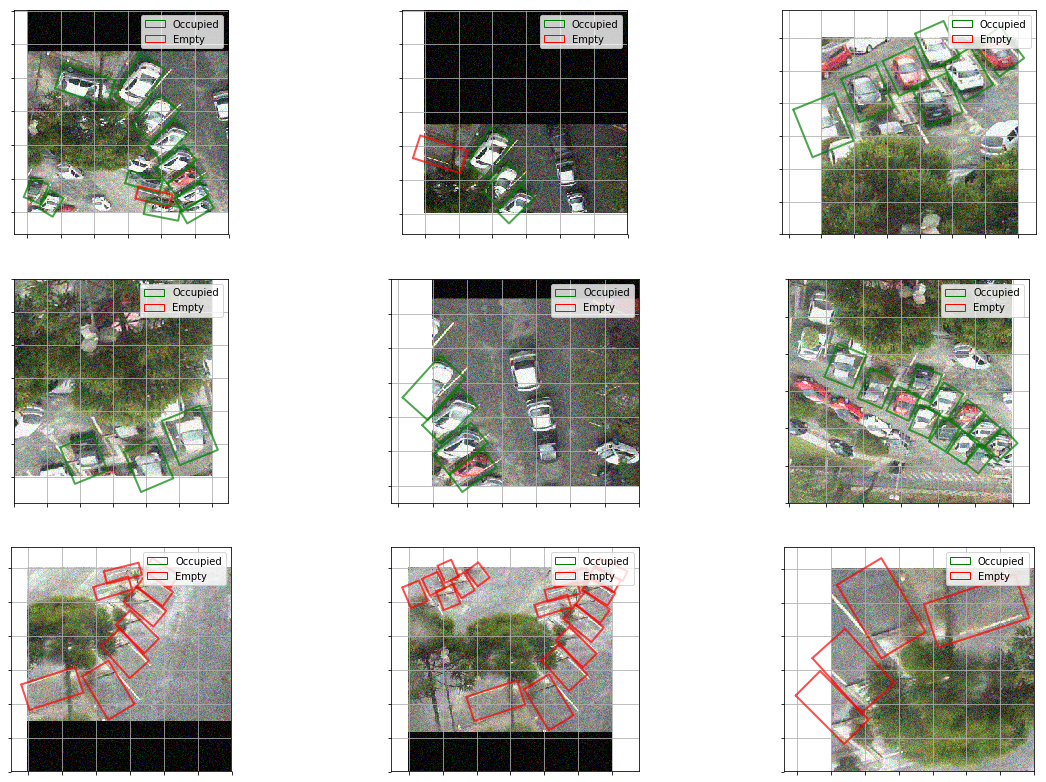

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(20,14))

for i, ax in enumerate(axes.flat):
    #ax.add_patch(patches.Rectangle(xy, rotated_bboxes[0][0][3], rotated_bboxes[0][0][2], rotated_bboxes[0][0][4]))
    #ax = fig.add_subplot(nrows=2, ncols=num_images // 2, index=idx + 1, xticks=[], yticks=[])
    show_truth(images[i], rotated_bboxes[i], labels[i], ax, linewidth=2)

### Define the model

In [20]:
def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.
    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.
    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor

In [21]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")

In [22]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):
        """
        Forward propagation.
        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

In [23]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.
    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.
    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 15,
                   'conv7': 18,
                   'conv8_2': 18,
                   'conv9_2': 18,
                   'conv10_2': 15,
                   'conv11_2': 15}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 5, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 5, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 5, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 5, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 5, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 5, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()  #Add xavier activations

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.
        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 5)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 5)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 5)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 5)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 5)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 5)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

In [24]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.
        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.006,
                      'conv7': 0.0728,
                      'conv8_2': 0.1396,
                      'conv9_2': 0.2064,
                      'conv10_2': 0.2732,
                      'conv11_2': 0.34}

        aspect_ratios = {'conv4_3': [0.5, 0.75, 1., 1.25, 1.75],
                         'conv7': [0.5, 0.75, 1., 1.25, 1.75, 3.],
                         'conv8_2': [0.5, 0.75, 1., 1.25, 1.75, 3.],
                         'conv9_2': [0.5, 0.75, 1., 1.25, 1.75, 3.],
                         'conv10_2': [0.5, 0.75, 1., 1.25, 1.75],
                         'conv11_2': [0.5, 0.75, 1., 1.25, 1.75]}
        
        rotation_angles = {0, -45, -90}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        ratio = torch.FloatTensor([ratio])
                        for angle in rotation_angles:
                            prior_boxes.append([cx, 
                                                cy, 
                                                obj_scales[fmap] * torch.sqrt(ratio), 
                                                obj_scales[fmap] / torch.sqrt(ratio), 
                                                angle])
                        
                        """
                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])
                        """

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            #decoded_locs = cxcy_to_xy(
            #    gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size


class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        #self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 5), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)
        
        loc_loss = 0

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)
            
            # Note may have to fix this!!!!
            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)
            
            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects))#.to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior
            

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            #true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)
            true_locs[i] = boxes[i][object_for_each_prior]
            
            if true_classes[i] != 0:
                loc_loss += torch.sum(true_locs[i, :, 0] - predicted_locs[i, :, 0]).abs() / predicted_locs[i, :, 2]
                loc_loss += torch.sum(true_locs[i, :, 1] - predicted_locs[i, :, 1]).abs() / predicted_locs[i, :, 3]
                loc_loss += torch.sum(torch.log(true_locs[i, :, 2] / predicted_locs[i, :, 2]))
                loc_loss += torch.sum(torch.log(true_locs[i, :, 3] / predicted_locs[i, :, 3]))
                loc_loss += torch.sum(torch.tan(true_locs[i, :, 4] - predicted_locs[i, :, 4]).abs())
            
        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        #loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg)#.to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss


In [ ]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

IOU???

In [26]:
class Line:
    # ax + by + c = 0
    def __init__(self, tensor1, tensor2):
        self.a = tensor2[1] - tensor1[1] #v2.y - v1.y 
        self.b = tensor1[0] - tensor2[0]#v1.x - v2.x
        self.c = torch.det(torch.stack((tensor2, tensor1)))#v2.cross(v1)

    def __call__(self, p):
        return self.a * p[0] + self.b * p[1] + self.c #self.a*p.x + self.b*p.y + self.c

    def intersection(self, other):
        # See e.g.     https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#Using_homogeneous_coordinates
        if not isinstance(other, Line):
            return NotImplemented
        w = self.a * other.b - self.b * other.a
        return torch.FloatTensor([
            (self.b * other.c - self.c * other.b) / w,
            (self.c * other.a - self.a * other.c) / w
        ])


def rectangle_vertices(cx, cy, w, h, a):
    radian = np.pi * a.double() / 180
    dx = w/2
    dy = h/2
    dxcos = dx * torch.cos(radian)
    dxsin = dx * torch.sin(radian)
    dycos = dy * torch.cos(radian)
    dysin = dy * torch.sin(radian)
    return (
        torch.FloatTensor([cx, cy]) + torch.FloatTensor([-dxcos - -dysin, -dxsin + -dycos]),
        torch.FloatTensor([cx, cy]) + torch.FloatTensor([dxcos - -dysin,  dxsin + -dycos]),
        torch.FloatTensor([cx, cy]) + torch.FloatTensor([dxcos -  dysin,  dxsin +  dycos]),
        torch.FloatTensor([cx, cy]) + torch.FloatTensor([-dxcos -  dysin, -dxsin +  dycos])
    )

def intersection_area(r1, r2):
    # r1 and r2 are in (center_x, center_y, width, height, rotation) representation
    # First convert these into a sequence of vertices

    rect1 = rectangle_vertices(r1[0], r1[1], r1[3], r1[2], r1[4])
    rect2 = rectangle_vertices(r2[0], r2[1], r2[3], r2[2], r2[4])
    # Use the vertices of the first rectangle as
    # starting vertices of the intersection polygon.
    intersection = rect1

    # Loop over the edges of the second rectangle
    for p, q in zip(rect2, rect2[1:] + rect2[:1]):
        if len(intersection) <= 2:
            break # No intersection

        line = Line(p, q)

        # Any point p with line(p) <= 0 is on the "inside" (or on the boundary),
        # any point p with line(p) > 0 is on the "outside".

        # Loop over the edges of the intersection polygon,
        # and determine which part is inside and which is outside.
        new_intersection = []
        line_values = [line(t) for t in intersection]
        for s, t, s_value, t_value in zip(
            intersection, intersection[1:] + intersection[:1],
            line_values, line_values[1:] + line_values[:1]):
            if s_value <= 0:
                new_intersection.append(s)
            if s_value * t_value < 0:
                # Points are on opposite sides.
                # Add the intersection of the lines to new_intersection.
                intersection_point = line.intersection(Line(s, t))
                new_intersection.append(intersection_point)

        intersection = new_intersection

    # Calculate area
    if len(intersection) <= 2:
        return 0

    #return 0.5 * sum(p.x*q.y - p.y*q.x for p, q in
    #                 zip(intersection, intersection[1:] + intersection[:1]))
    return 0.5 * sum(p[0] * q[1] - p[1] * q[0] for p, q in
                     zip(intersection, intersection[1:] + intersection[:1]))


def find_jaccard_overlap(predicted_prior_set, true_prior_set):
    intersection = torch.zeros(len(predicted_prior_set), len(true_prior_set))
    area1 = torch.zeros(predicted_prior_set.shape[0])
    area2 = torch.zeros(true_prior_set.shape[0])
        
    for i, box1 in enumerate(predicted_prior_set):
        for j, box2 in enumerate(true_prior_set):
            intersection[i][j] = intersection_area(box1, box2)
            
            if i == 0:
                area2[j] = box2[3] * box2[2]
        area1[i] = box1[3] * box1[2]
    
    union = area1.unsqueeze(1) + area2.unsqueeze(0) - intersection
    return intersection / union 

In [27]:
n_classes = 3  # number of different types of objects
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 64  # batch size
start_epoch = 0  # start at this epoch
epochs = 200  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 64  # print training or validation status every __ batches
lr = 1e-3  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes 
                    #(sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

In [28]:
if checkpoint is None:
    model = SSD300(n_classes=n_classes)
    # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_loss = checkpoint['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']


Loaded base model.



In [29]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored


In [30]:
# Move to default device
model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

/home/pooya32kh/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
for epoch in range(start_epoch, epochs):
    print('epoch: {}'.format(epoch))
    breakpoint()
    train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

epoch: 0
> <ipython-input-31-18374b3c129e>(4)<module>()
-> train(train_loader=train_loader,
(Pdb) step
> <ipython-input-31-18374b3c129e>(5)<module>()
-> model=model,
(Pdb) 
> <ipython-input-31-18374b3c129e>(6)<module>()
-> criterion=criterion,
(Pdb) 
> <ipython-input-31-18374b3c129e>(7)<module>()
-> optimizer=optimizer,
(Pdb) step
> <ipython-input-31-18374b3c129e>(8)<module>()
-> epoch=epoch)
(Pdb) step
--Call--
> <ipython-input-29-b87201cadb79>(1)train()
-> def train(train_loader, model, criterion, optimizer, epoch):
(Pdb) step
> <ipython-input-29-b87201cadb79>(10)train()
-> model.train()  # training mode enables dropout
(Pdb) 
--Call--
> /home/pooya32kh/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py(976)train()
-> def train(self, mode=True):
(Pdb) 
> /home/pooya32kh/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py(987)train()
-> self.training = mode
(Pdb) 
--Call--
> /home/pooya32kh/miniconda3/envs/pytorch/lib/python3.7/si